## Divvy Bike Share Analysis

In [2]:
import pandas as pd
import numpy  as np
Mar_2023 = pd.read_csv("202303-divvy-tripdata.csv")
Apr_2023 = pd.read_csv("202304-divvy-tripdata.csv")
May_2023 = pd.read_csv("202305-divvy-tripdata.csv")
Jun_2023 = pd.read_csv("202306-divvy-tripdata.csv")
Jul_2023 = pd.read_csv("202307-divvy-tripdata.csv")
Aug_2023 = pd.read_csv("202308-divvy-tripdata.csv")
Sep_2023 = pd.read_csv("202309-divvy-tripdata.csv")
Oct_2023 = pd.read_csv("202310-divvy-tripdata.csv")
Nov_2023 = pd.read_csv("202311-divvy-tripdata.csv")
Dec_2023 = pd.read_csv("202312-divvy-tripdata.csv")
Jan_2024 = pd.read_csv("202401-divvy-tripdata.csv")
Feb_2024 = pd.read_csv("202402-divvy-tripdata.csv")


In [3]:
data = [Mar_2023, Apr_2023, May_2023, Jan_2024, Jul_2023, Aug_2023, Sep_2023, Oct_2023, Nov_2023, Dec_2023, Jan_2024, Feb_2024]

# Create a dataframe and verify the dimensions 
df = pd.concat(data, ignore_index=True)
print(df.shape)
print(df.columns)

# Unify the format of started_at and ended_at columns
df['started_at'] = pd.to_datetime(df['started_at'])
df['ended_at'] = pd.to_datetime(df['ended_at'])

print(df['started_at'].head())


(5132423, 13)
Index(['ride_id', 'rideable_type', 'started_at', 'ended_at',
       'start_station_name', 'start_station_id', 'end_station_name',
       'end_station_id', 'start_lat', 'start_lng', 'end_lat', 'end_lng',
       'member_casual'],
      dtype='object')
0   2023-03-16 08:20:34
1   2023-03-04 14:07:06
2   2023-03-31 12:28:09
3   2023-03-22 14:09:08
4   2023-03-09 07:15:00
Name: started_at, dtype: datetime64[ns]


### Process Data

In [4]:
# Create new columns
df['month'] = df['started_at'].dt.month
df['day'] = df['started_at'].dt.day_of_week
df['tripDuration'] = df['ended_at'] - df['started_at']
df['tripDuration'] = df['tripDuration'].dt.total_seconds().astype(int)

# Verify no discrepancies in the values of the columns member_type and rideable_type
values_member_type = df['member_casual'].value_counts()
print("Values of member_casual:", list(values_member_type.index))

values_rideable_type= df['rideable_type'].value_counts()
print("Values of rideable_type:", list(values_rideable_type.index))

# Identify duplicates & delete them 
value_counts = df['ride_id'].value_counts()
duplicates = value_counts[value_counts > 1]

df = df.drop_duplicates(subset=['ride_id'])
value_counts = df['ride_id'].value_counts()
duplicates = value_counts[value_counts > 1]
print("Number of duplicates(should be 0):", duplicates.sum())

# Identify trips with negative tripDuration and remove them
negative_trip_duration = (df['tripDuration'] < 0).sum()

df = df[df['tripDuration'] >= 0]
negative_trip_duration = (df['tripDuration'] < 0).sum()
print("Number of negative trips(should be 0):", negative_trip_duration)

# Remove rows wit NaN values
df = df.dropna()

df.to_csv('tripdata_cleaned.csv', index=False)
print("DataFrame successfully written to tripdata_cleaned.csv")


Values of member_casual: ['member', 'casual']
Values of rideable_type: ['electric_bike', 'classic_bike', 'docked_bike']
Number of duplicates(should be 0): 0
Number of negative trips(should be 0): 0
DataFrame successfully written to tripdata_cleaned.csv


### Analyze Data

Text(0.5, 1.0, 'User Count: Member vs Casual')

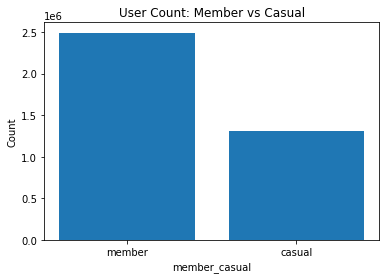

In [5]:
# Graph user count
import matplotlib.pyplot as plt
value_counts = df['member_casual'].value_counts()
plt.bar(value_counts.index, value_counts.values)
plt.xlabel('member_casual')
plt.ylabel('Count')
plt.title('User Count: Member vs Casual')


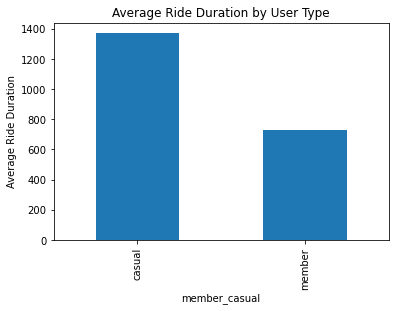

In [6]:
# Plot the ride duration between casual users & members 
average_duration = df.groupby('member_casual')['tripDuration'].mean()
average_duration.plot(kind='bar')
plt.xlabel('member_casual')
plt.ylabel('Average Ride Duration')
plt.title('Average Ride Duration by User Type')
plt.show()

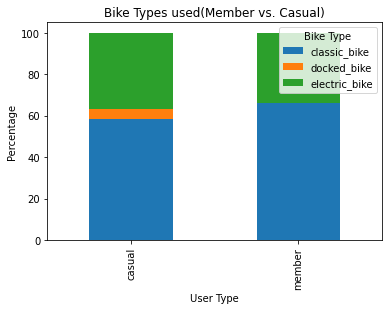

In [7]:
# Calculate the percentage of each rideable type for each group
percentage_df = df.groupby(['member_casual', 'rideable_type']).size().unstack(fill_value=0)
percentage_df = percentage_df.div(percentage_df.sum(axis=1), axis=0) * 100

# Plot the bar graph
percentage_df.plot(kind='bar', stacked=True)

# Add labels and title
plt.xlabel('User Type')
plt.ylabel('Percentage')
plt.title('Bike Types used(Member vs. Casual)')

# Show plot
plt.legend(title='Bike Type')
plt.show()

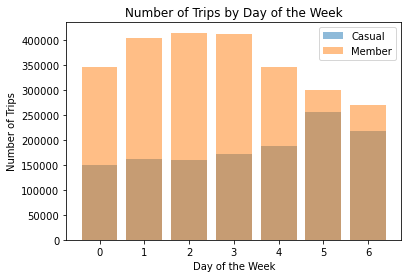

In [8]:
# Filter data for casual and member users
casual_data = df[df['member_casual'] == 'casual']
member_data = df[df['member_casual'] == 'member']

# Count the trips for each day of the week
casual_counts = casual_data['day'].value_counts().sort_index()
member_counts = member_data['day'].value_counts().sort_index()

# Plot the bar graph
plt.bar(casual_counts.index, casual_counts.values, label='Casual', alpha=0.5)
plt.bar(member_counts.index, member_counts.values, label='Member', alpha=0.5)

# Add labels and title
plt.xlabel('Day of the Week')
plt.ylabel('Number of Trips')
plt.title('Number of Trips by Day of the Week')
plt.legend()

plt.show()

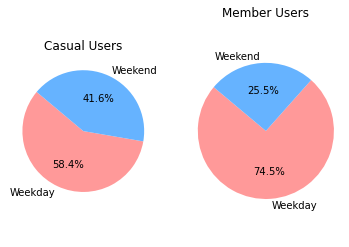

In [9]:
# Separate data into weekdays and weekends
weekday_data = df[df['day'] < 5]  # Monday to Friday
weekend_data = df[df['day'] >= 5]  # Saturday and Sunday

# Calculate total trip duration for weekdays and weekends for casual users
casual_weekday_duration = weekday_data[weekday_data['member_casual'] == 'casual']['tripDuration'].sum()
casual_weekend_duration = weekend_data[weekend_data['member_casual'] == 'casual']['tripDuration'].sum()

# Calculate total trip duration for weekdays and weekends for member users
member_weekday_duration = weekday_data[weekday_data['member_casual'] == 'member']['tripDuration'].sum()
member_weekend_duration = weekend_data[weekend_data['member_casual'] == 'member']['tripDuration'].sum()

# Plot pie charts
labels = ['Weekday', 'Weekend']
colors = ['#ff9999', '#66b3ff']

# Pie chart for casual users
plt.subplot(1, 2, 1)
sizes = [casual_weekday_duration, casual_weekend_duration]
plt.pie(sizes, colors=colors, labels=labels, autopct='%1.1f%%', startangle=140)
plt.title('Casual Users')

# Pie chart for member users
plt.subplot(1, 2, 2)
sizes = [member_weekday_duration, member_weekend_duration]
plt.pie(sizes, colors=colors, labels=labels, autopct='%1.1f%%', startangle=140)
plt.title('Member Users')

# Equal aspect ratio ensures that pie is drawn as a circle
plt.axis('equal')

# Show plot
plt.show()


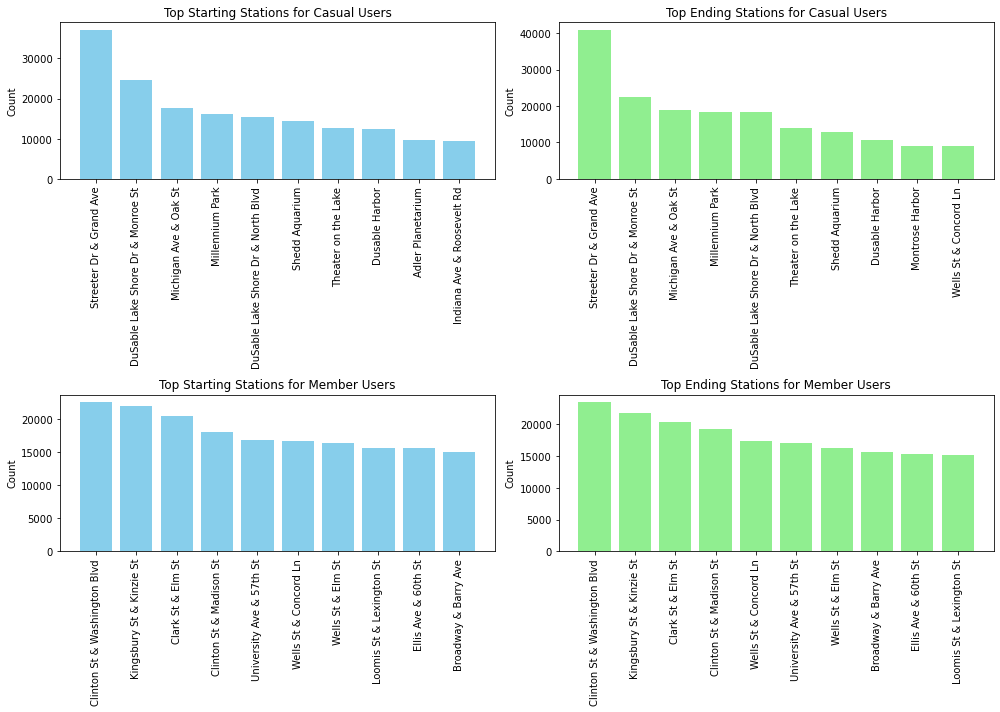

In [10]:
# Separate data for casual and member users
casual_df = df[df['member_casual'] == 'casual']
member_df = df[df['member_casual'] == 'member']

# Plotting for Casual users
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Get top starting and ending stations for casual users
casual_start_counts = casual_df['start_station_name'].value_counts().head(10)
casual_end_counts = casual_df['end_station_name'].value_counts().head(10)

# Plot top starting stations for casual users
axes[0, 0].bar(casual_start_counts.index, casual_start_counts.values, color='skyblue')
axes[0, 0].set_title('Top Starting Stations for Casual Users')
axes[0, 0].set_ylabel('Count')
axes[0, 0].tick_params(axis='x', rotation=90) 

# Plot top ending stations for casual users
axes[0, 1].bar(casual_end_counts.index, casual_end_counts.values, color='lightgreen')
axes[0, 1].set_title('Top Ending Stations for Casual Users')
axes[0, 1].set_ylabel('Count')
axes[0, 1].tick_params(axis='x', rotation=90) 

# Plotting for Member users
# Get top starting and ending stations for member users
member_start_counts = member_df['start_station_name'].value_counts().head(10)
member_end_counts = member_df['end_station_name'].value_counts().head(10)

# Plot top starting stations for member users
axes[1, 0].bar(member_start_counts.index, member_start_counts.values, color='skyblue')
axes[1, 0].set_title('Top Starting Stations for Member Users')
axes[1, 0].set_ylabel('Count')
axes[1, 0].tick_params(axis='x', rotation=90)  

# Plot top ending stations for member users
axes[1, 1].bar(member_end_counts.index, member_end_counts.values, color='lightgreen')
axes[1, 1].set_title('Top Ending Stations for Member Users')
axes[1, 1].set_ylabel('Count')
axes[1, 1].tick_params(axis='x', rotation=90) 

plt.tight_layout() # Adjust spacing between subplots
plt.show()

### Findings
- Majority of rides are from member users compared to casual users
- Casual riders have longer trip duration than member riders
- Docked bikes are the least popular type of bike used
- Casual riders have more trips on the weekend compared to member riders that have mroe trips on the weekdays. Tuesday to Thursday are the most popular days among member riders.
- The top ten starting and ending stations are the same for member users with varying order amongst the last three stations. This suggests that the members have a routine route. For casual members, the top 8 starting and ending stations are the same with slight varying order amongest the last three stations. 

### Recommendation from the findings

The analysis shows a clear distinction in the usage patterns between member users and casual users of the bike service. Member users tend to utilize the service during typical commuting hours, possibly to bypass heavy traffic during rush hours. Conversely, casual users prefer weekends and non-rush hours, especially in the summer season, indicating a recreational or leisurely usage pattern.

Based on these patterns, we can infer that member users are likely residents familiar with local commuting needs, while casual users may include tourists or occasional visitors. This distinction implies that member users and casual users represent distinct user groups with different preferences and behaviors.

Consequently, converting casual users into member users is unlikely to be straightforward due to the fundamental differences in their usage habits and motivations. We can explore marketing initiatives and offer summer discounts as incentives to attract casual users.